In [2]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from copy import deepcopy

In [3]:
from geography_helper import *
from schoolscraper import get_school_scores
from walkscraper import clean_scores
from haystacks_importer import *

In [4]:
#Listings and their coordinates
listings = pd.read_csv('data/GA_LISTINGS_SALES_V2.csv', index_col = 0)
listing_coords = listings[['latitude', 'longitude']].values

#GA boundary
GA = import_GA_boundary_file('GAboundary.txt')

#Import school dfs & concatenate
greatschools = get_school_scores()

#Concatenate all school lists and drop duplicates (schools which are in multiple categories)
allschools = pd.concat(list(greatschools.values()), axis = 0)
assert allschools.id.unique().shape[0] == allschools.drop_duplicates().shape[0]
allschools = allschools.drop_duplicates().rename({'lat':'latitude', 'long': 'longitude'}, axis = 1)

#Remove schools with incorrect coordinates (2 schools)
schools_gdf = places_to_geom(allschools)
schools_gdf = schools_gdf[check_in_boundary(schools_gdf, GA)]
schools_gdf = schools_gdf[schools_gdf.rating.notnull()]
schools = pd.DataFrame(schools_gdf).drop('geometry', axis = 1)

#Import census tracts and use to attach to listings
censusgdf = gpd.read_file('data/tl_2021_13_tract/tl_2021_13_tract.shp')
listings_gdf = add_census_tracts(listings, censusgdf)
listings = pd.DataFrame(listings_gdf).drop('geometry', axis = 1).rename({'tract_containing':'census_tract'}, axis = 1)

# Import walk scores
walkscores = pd.read_csv('data/walkscores.csv')
walkscores = clean_scores(walkscores).rename({'zipcode':'zip'}, axis = 1)

#Import NRI data
nri_shp = gpd.read_file('data/NRI_Shapefile_CensusTracts/NRI_Shapefile_CensusTracts.shp')

#Subset GA
nriGA = nri_shp[nri_shp['STATE'] == 'Georgia']
#Original dataset is in the wrong coordinates
nriGA = nriGA.to_crs("EPSG:4326")
#Replace -9999 w/NaNs
nriGA = nriGA.applymap(lambda x: np.nan if x == -9999.0 else x)
GApd = gpd.GeoDataFrame(data = pd.DataFrame({'state':['GA']}), geometry = [GA])

#Can delete full df
del nri_shp

#Add NRI tract data (the TRACTFIPS for GA in the NRA set do NOT align with official census data; using the tracts based on NRI so that we can merge that data)
listings_gdf = add_census_tracts(listings, nriGA, id_col = 'TRACTFIPS')\
    .rename({'tract_containing':'nri_tract'}, axis = 1)
listings = pd.DataFrame(listings_gdf).drop('geometry',axis = 1)

#Once tracts are added, only need data from nriGA
nriGA = pd.DataFrame(nriGA).drop('geometry', axis =1)

#Import crime data
crime = pd.read_csv('data/crime_rating_zipcode.csv', index_col = 0, dtype = str)

#Import POIs
df_brew = pd.read_csv('data/breweries.csv')
df_sb = pd.read_csv('data/starbucks.csv')
df_wh = pd.read_csv('data/whole_foods.csv')
df_wb = pd.read_csv('data/wine_bars.csv')

for poi in [df_brew, df_sb, df_wh, df_wb]:
    poi = filter_by_boundary(poi, GA)

progress: 100%|████████████████████████████████████████| 680/680 [00:00<00:00, 890.23it/s]


Dropped 180 rows which were outside the boundary
500 rows are remaining


progress: 100%|████████████████████████████████████████| 461/461 [00:00<00:00, 875.12it/s]


Dropped 119 rows which were outside the boundary
342 rows are remaining


progress: 100%|████████████████████████████████████████| 118/118 [00:00<00:00, 856.93it/s]


Dropped 25 rows which were outside the boundary
93 rows are remaining


progress: 100%|████████████████████████████████████████| 842/842 [00:00<00:00, 853.50it/s]

Dropped 211 rows which were outside the boundary
631 rows are remaining


In [98]:
features = listings.copy()
features = features.drop_duplicates()
features.drop('lot_size', axis = 1, inplace = True)

In [99]:
#Extract beds from details and fill na's from this
beds_detail = features['details'].apply(lambda x: re.findall('[0-9,.]+ Beds', x)[0].split()[0] 
                                        if re.findall('[0-9]+ Beds', x) else np.nan)
features['beds'] = features['beds'].fillna(beds_detail)

### XXX should come back and check this method vs. starting with detail extraction, then filling from bath_full and bath_half columns
#Create single column baths = sum of known bath_full and bath_half if at least one NaN, or fill from detail column if both unknown
#Leaves NaN if no bath in details listing, and no value for bath_full or bath_half

#Change 1/2 and + symbols to .5, e.g. 4+ to 4.5 and 3 1/2 to 3.5
#Rounding these leads to, e.g. 5 and 4, or the total number of rooms (full + half rooms)
#It looks like only bathrooms have this form, and those with half baths in details all have this form
features['details'] = features['details'].apply(lambda x: x.replace('½', '.5').replace('+', '.5'))

#Extract baths from details
bath_detail = features['details'].apply(lambda x: np.ceil(float(re.findall('[0-9,.]+ Bath',x)[0].split()[0])) 
                                        if re.findall('[0-9]+ Bath',x) else np.nan).head(50)

#both_na = NaN if baths_full AND baths_half are NaN,  0 if at least one non-NaN
# series + both_na is NaN where both were NaN, and returns the value of the series otherwise
both_na = (features['baths_full'].isna() & features['baths_half'].isna()).apply(lambda x: np.nan if x else 0)

#sum of known baths + both_na 
features['baths'] = (features['baths_full'].fillna(0) + features['baths_half'].fillna(0)) + both_na

#Fill remaining NaN from detail extraction
features['baths'] = features['baths'].fillna(bath_detail)
features.drop(['baths_full', 'baths_half'], axis = 1, inplace = True)

sqft_detail = features['details'].apply(lambda x: re.findall('[0-9,\,]+ Sq Ft', x)[0].split()[0].replace(',','') 
                                        if re.findall('[0-9,\,]+ Sq Ft', x) else np.nan)
features['square_footage'] = features.square_footage.apply(lambda x: np.nan if x == 0 else x)
features['square_footage'] = features['square_footage'].fillna(sqft_detail)

In [100]:
features=features[~(features.baths>12)]
features=features[~(features.beds>12)]
features = features[(features.price > 5000) & (features.price < 50e6)]
features=features[~(features.square_footage>35000)] 
features=features[~(features["details"].str.contains(r'^Commercial|^Other'))]
features = features[(~features["details"].str.contains(r'^Lots')) | features['beds'].notnull()]
features = features[(features.square_footage >= 500)|(features.square_footage.isna())]

In [101]:
# features.loc[features.index[[4828,7636,7720,9353,10463,12653]]]

In [102]:
# features.sort_values('price', ascending=False)

In [103]:
features.shape[0]

13086

In [104]:
# listings[listings.baths_full == 0]

In [105]:
features.baths.isna().sum()

370

In [106]:
features.beds.isna().sum()

239

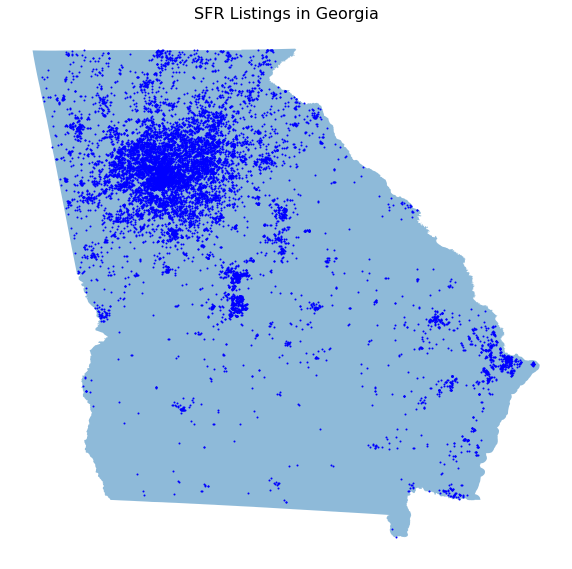

In [107]:
fix, ax = plt.subplots(figsize=(10,10))
GApd.plot(ax =ax, alpha = 0.5)
places_to_geom(features).plot(ax =ax, color = 'blue', markersize = 1)
plt.title('SFR Listings in Georgia', fontsize = 16)
plt.axis('off')
plt.savefig('all_listings.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

In [108]:
features.shape[0]

13086

# Feature creation

## NRI

In [139]:
# # #Import NRI data
nri_shp = gpd.read_file('data/NRI_Shapefile_CensusTracts/NRI_Shapefile_CensusTracts.shp')

#Subset GA
nriGA = nri_shp[nri_shp['STATE'] == 'Georgia']
#Original dataset is in the wrong coordinates
nriGA = nriGA.to_crs("EPSG:4326")
#Replace -9999 w/NaNs
nriGA = nriGA.applymap(lambda x: np.nan if x == -9999.0 else x)

del nri_shp

In [140]:
nriGA['EAL_ratio_test'] = nriGA['EAL_VALB'] / nriGA['BUILDVALUE']

This ratio does seem to be heavily biased towards two areas. Leave it for now, but may want to consider other NRI features as well.

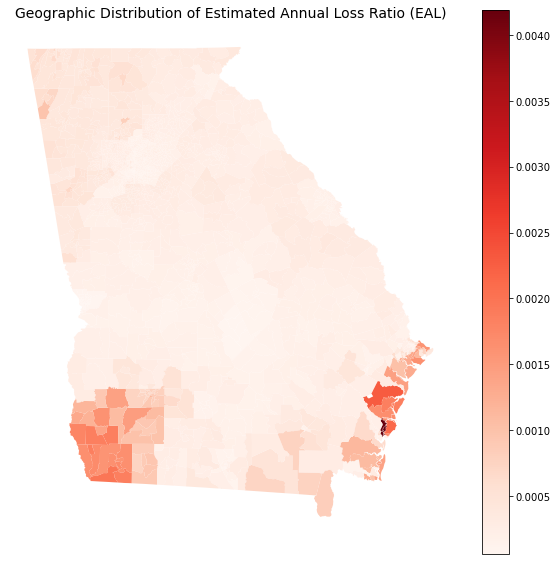

In [146]:
fig, ax = plt.subplots(figsize = (10,10))
nriGA.plot(column = 'EAL_ratio_test', ax = ax, legend = True, cmap = 'Reds')
ax.set_title('Geographic Distribution of Estimated Annual Loss Ratio (EAL)', fontsize = 14)
plt.axis('off')
fig.savefig('EAL_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

For example, social vulnerability: susceptibility of social groups to the adverse impacts of natural hazards, including disproportionate death, injury, loss, or disruption of livelihood.

In [112]:
# nriGA.plot(column = 'SOVI_SCORE')

In [113]:
#Example NRI feature
features = features.merge(pd.concat([nriGA['TRACTFIPS'] , nriGA['EAL_VALB'] / nriGA['BUILDVALUE']], axis = 1)\
    .rename({'TRACTFIPS':'tract', 0: 'EAL_ratio'}, axis = 1), how = 'left', left_on = 'nri_tract', right_on = 'tract').drop('tract', axis = 1)

In [114]:
risks = ['TRND','SWND','LTNG','HWAV','HAIL','CWAV']
loss_rates = []
for risk in [x+'_EALB' for x in risks]:
    loss_rates.append(nriGA[risk] / nriGA['BUILDVALUE'])
loss_rates = pd.concat(loss_rates, axis = 1)
loss_rates.columns = [x+'_loss_rate' for x in risks]
loss_rates = pd.concat([nriGA['TRACTFIPS'], loss_rates], axis = 1)

In [115]:
features = features.merge(loss_rates, how = 'left', left_on = 'nri_tract', right_on = 'TRACTFIPS')

## School

In [116]:
schools.head()

,id,districtID,districtName,districtCity,latitude,longitude,name,gradeLevels,address,rating,ratingScale,schoolType,zipcode,studentsPerTeacher,parentRating
0,1038,73,Fulton County School District,Atlanta,34.071564,-84.363319,Sweet Apple Elementary School,PK-5,"12025 Etris Road, 30075, Roswell",10.0,Above average,public,30075,15.0,4
0,1108,82,Gwinnett County School District,Lawrenceville,34.044102,-83.924065,Fort Daniel Elementary School,PK-5,"1725 Auburn Road, 30019, Dacula",10.0,Above average,public,30019,14.0,5
0,1111,82,Gwinnett County School District,Lawrenceville,33.996933,-83.937210,Dyer Elementary School,PK-5,"1707 Hurricane Shoals Road Northeast, 30019, D...",10.0,Above average,public,30019,15.0,3
0,1503,124,Oconee County Schools,Watkinsville,33.914272,-83.506477,Malcom Bridge Elementary School,K-5,"2600 Malcom Bridge Road, 30622, Bogart",10.0,Above average,public,30622,16.0,4
0,3690,44,Columbia County School District,Evans,33.573559,-82.107941,River Ridge Elementary School,PK-5,"4109 Mullikin Road, 30809, Evans",10.0,Above average,public,30809,15.0,4


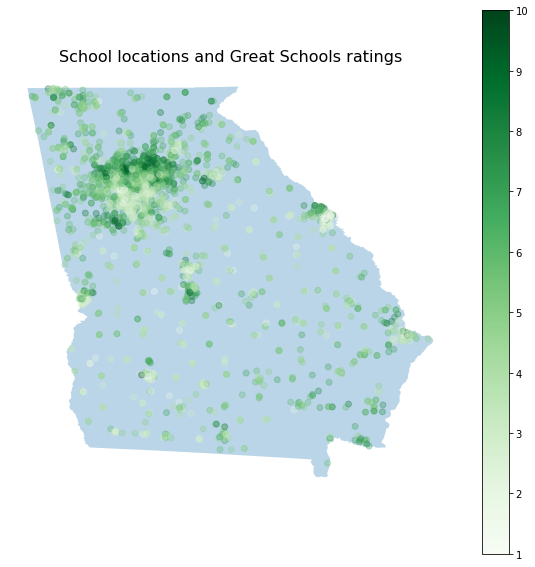

In [117]:
fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .3)
#markersize = schools.rating ** 2
places_to_geom(schools).plot(column = 'rating',  ax = ax, alpha = .3, legend = True, cmap = 'Greens')
ax.axis('off')
ax.set_title('School locations and Great Schools ratings', fontsize = 16)
# ax.legend()
fig.savefig('school_ratings.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

In [118]:
#Example school feature
#This finds the average rating of the 5 closest schools (restricted to 30 km)
features['avg_nearby_school_rating'] = apply_local_aggfunc(features, schools, lambda x: x['rating'].mean(), 5, limit = 30)

In [119]:
#Make closest_school_rating to help impute for ones with none in 30km
features['closest_school_rating'] = apply_local_aggfunc(features, schools, lambda x: x['rating'].max(), 1)

In [120]:
good_elementary_schools = greatschools['e'].rename({'lat': 'latitude', 'long':'longitude'}, axis = 1)
good_elementary_schools = good_elementary_schools[good_elementary_schools.rating >= 7]

In [121]:
features['dist_to_good_e_school'] = min_distance(features, good_elementary_schools)

## Walkscores

In [122]:
#Merge walkscores
features = features.merge(walkscores, on = 'zip', how = 'left')
features['Transit Score'] = features['Transit Score'].fillna(0)

## haystacks POIs

In [123]:
f = open('data/all_zips_grocery_store.json')
hstacks_poi1 = json.load(f)
f.close()

f = open('data/all_zips_restaurant.json')
hstacks_poi2 = json.load(f)
f.close()

destinations = ['amusement_park', 'bowling_alley', 'art_gallery', 'bar', 'cafe', 
                'book_store', 'clothing_store', 'department_store', 
                'jewelry_store', 'gym', 'movie_theater', 'museum', 'night_club',
                'park', 'restaurant', 'shopping_mall', 'shoe_store', 'zoo']

transit = ['bus_station', 'light_rail_station', 'subway_station', 'train_station', 'transit_station']

hstacks_destination_df1 = import_haystacks_destinations_GA(hstacks_poi1, destinations)
hstacks_destination_df2 = import_haystacks_destinations_GA(hstacks_poi2,destinations)
hstacks_destinations = pd.concat([hstacks_destination_df1, hstacks_destination_df2], axis = 0).drop_duplicates(subset='place_id', keep="first")

hstacks_transit_df1 = import_haystacks_destinations_GA_no_rating(hstacks_poi1, transit)
hstacks_transit_df2 = import_haystacks_destinations_GA_no_rating(hstacks_poi2, transit)
hstacks_transit = pd.concat([hstacks_transit_df1, hstacks_transit_df2], axis = 0).drop_duplicates(subset='place_id', keep="first")

#Can delete the raw jsons after import
del hstacks_poi1, hstacks_poi2

In [124]:
#Filtering not necessary, lat/long all correct
# hstacks_destinations = filter_by_boundary(hstacks_destinations, GA)

In [125]:
parks = hstacks_destinations[hstacks_destinations['poi_types'].apply(lambda x: ('park' in x) and ('rv_park' not in x))]
features['dist_to_park'] = min_distance(features,parks)

In [126]:
malls = hstacks_destinations[hstacks_destinations['poi_types'].apply(lambda x: ('shopping_mall' in x) and ('store' not in x) and ('restaurant' not in x))]
features['dist_to_mall'] = min_distance(features, malls)

In [127]:
attractions = hstacks_destinations[hstacks_destinations['poi_types'].apply(lambda x: True if
                                       set(x).intersection(['art_gallery', 'movie_theater', 'museum'])
                                       else False)]

features['dist_to_attraction'] = min_distance(features, attractions)
features['num_nearby_attractions'] = apply_local_aggfunc(features, attractions, lambda x: len(x), 100, limit = 20)

In [128]:
overall_attraction_types = list(set(destinations).difference(['book_store', 'clothing_store', 'shoe_store']))
overall_attractions = hstacks_destinations[hstacks_destinations['poi_types'].apply(lambda x: True if
                                    set(x).intersection(overall_attraction_types)
                                    and set(x).intersection(['gas_station', 'convenience_store']) == set()                      
                                    else False)].head(50)
features['num_overall_attractions'] = apply_local_aggfunc(features, overall_attractions, lambda x: len(x), 2000, limit = 30)

In [129]:
features['dist_to_transit'] = min_distance(features,hstacks_transit)

## Posh features

In [130]:
miles5=8.04672

features['num_sb_within_5']=apply_local_aggfunc(features, df_sb, lambda x: len(x), n=100, limit=miles5)
features['num_wb_within_5']=apply_local_aggfunc(features, df_wb, lambda x: len(x), n=100, limit=miles5)
features['num_wh_within_5']=apply_local_aggfunc(features, df_wh, lambda x: len(x), n=100, limit=miles5)
features['num_brew_within_5']=apply_local_aggfunc(features,df_brew, lambda x: len(x), n=100, limit=miles5)

df_wb_brew = pd.concat([df_wb,df_brew]).reset_index(drop=True).drop_duplicates(subset=['place_id'])
features['num_wb_brew_within_5']=apply_local_aggfunc(features, df_wb_brew, lambda x: len(x), n=100, limit=miles5)
features['posh_total'] = features['num_sb_within_5'] + features['num_wh_within_5'] + features['num_wb_brew_within_5']

## Crime data

In [131]:
features = features.merge(crime[['census_zcta5_geoid', 'property_crime_total_rate', 'property_crime_theft_rate']]
                          , how = 'left', left_on = 'zip', right_on = 'census_zcta5_geoid')\
                                    .drop('census_zcta5_geoid',axis = 1)
features.loc[:,['property_crime_total_rate', 'property_crime_theft_rate']] = features.loc[:,['property_crime_total_rate', 'property_crime_theft_rate']].astype(float)

# Export features (pre impute/scale/...)

Drop all location identifiers except lat/long, and unused features.

In [132]:
features = features.select_dtypes(include=np.number).drop(['unit_count', 'transaction_type', 
                                                    'special_features', 'listing_status', 'listing_special_features'], axis = 1)

In [133]:
features.columns

Index(['latitude', 'longitude', 'beds', 'square_footage', 'year_built',
       'price', 'baths', 'EAL_ratio', 'TRND_loss_rate', 'SWND_loss_rate',
       'LTNG_loss_rate', 'HWAV_loss_rate', 'HAIL_loss_rate', 'CWAV_loss_rate',
       'avg_nearby_school_rating', 'closest_school_rating',
       'dist_to_good_e_school', 'Bike Score', 'Transit Score', 'Walk Score',
       'dist_to_park', 'dist_to_mall', 'dist_to_attraction',
       'num_nearby_attractions', 'num_overall_attractions', 'dist_to_transit',
       'num_sb_within_5', 'num_wb_within_5', 'num_wh_within_5',
       'num_brew_within_5', 'num_wb_brew_within_5', 'posh_total',
       'property_crime_total_rate', 'property_crime_theft_rate'],
      dtype='object')

In [136]:
len(['beds', 'square_footage', 'year_built',
       'price', 'baths', 'EAL_ratio', 'TRND_loss_rate', 'SWND_loss_rate',
       'LTNG_loss_rate', 'HWAV_loss_rate', 'HAIL_loss_rate', 'CWAV_loss_rate',
       'avg_nearby_school_rating', 'closest_school_rating',
       'dist_to_good_e_school', 'Bike Score', 'Transit Score', 'Walk Score',
       'dist_to_park', 'dist_to_mall', 'dist_to_attraction',
       'num_nearby_attractions', 'num_overall_attractions', 'dist_to_transit',
       'num_sb_within_5', 'num_wb_within_5', 'num_wh_within_5',
       'num_brew_within_5', 'num_wb_brew_within_5', 'posh_total',
       'property_crime_total_rate', 'property_crime_theft_rate'])

32

In [134]:
features = features[['latitude', 'longitude', 'beds',
 'price',
 'baths',
 'EAL_ratio',
 'avg_nearby_school_rating',
 'closest_school_rating',
 'Transit Score',
 'square_footage',
 'dist_to_good_e_school',
 'Walk Score',
 'dist_to_transit',
'num_nearby_attractions',
 'posh_total',
             'num_brew_within_5',
             'num_wb_within_5',
 'property_crime_total_rate',
 'property_crime_theft_rate']]

In [138]:
len(['beds',
 'price',
 'baths',
 'EAL_ratio',
 'avg_nearby_school_rating',
 'closest_school_rating',
 'Transit Score',
 'square_footage',
 'dist_to_good_e_school',
 'Walk Score',
 'dist_to_transit',
'num_nearby_attractions',
 'posh_total',
             'num_brew_within_5',
             'num_wb_within_5',
 'property_crime_total_rate',
 'property_crime_theft_rate'])

17

In [135]:
# features.to_csv('combined_features.csv')